In [149]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn import decomposition
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import KFold
from scipy.stats import zscore
import pingouin as pg

In [150]:
data = pd.read_csv('/Users/vappaji/Documents/Capstone/merged_output.csv').drop(columns=['id1','id2','time','x','y'])

df_dedup = data.groupby(['source_file','level'], as_index=False).mean()
df_pivoted = df_dedup.set_index(['source_file', 'level']).unstack('level')
df_pivoted.columns = [f'{level}-{var}' for var, level in df_pivoted.columns]

In [151]:
df_pivoted

,100.0-air,125.0-air,150.0-air,175.0-air,200.0-air,225.0-air,250.0-air,275.0-air,300.0-air,350.0-air,...,775.0-vwnd,800.0-vwnd,825.0-vwnd,850.0-vwnd,875.0-vwnd,900.0-vwnd,925.0-vwnd,950.0-vwnd,975.0-vwnd,1000.0-vwnd
source_file,,,,,,,,,,,,,,,,,,,,,
all_10.0_20110110.csv,207.413830,210.518796,214.995488,214.154044,213.098147,213.963182,218.273788,223.780873,229.004029,237.204198,...,5.309322,4.896392,4.509763,4.350123,4.263043,4.245074,4.246109,4.244572,4.247834,4.244642
all_1001648.0_20060426.csv,219.047095,221.215176,222.542911,222.970458,222.127589,220.170907,219.162380,220.754518,224.835938,232.938454,...,2.212741,1.955725,1.250403,0.516583,-0.046716,-0.457568,-0.350980,0.119724,0.342932,0.402344
all_1001649.0_20060422.csv,213.857194,218.010995,224.098501,228.290491,228.622689,227.697120,226.497048,226.884731,228.483006,233.299752,...,7.159631,6.454129,5.330197,3.969531,2.945703,2.675919,3.304221,3.577203,3.629681,3.513052
all_1001665.0_20060423.csv,209.801834,213.656330,216.467429,219.289640,219.492695,220.659782,224.702089,228.963659,232.577326,240.685522,...,6.214542,6.210904,6.215558,6.215482,6.210251,6.214334,6.209747,6.208548,6.210101,6.214194
all_1001671.0_20060412.csv,210.518552,210.658872,212.362492,213.836853,215.488102,218.848508,222.867143,226.576820,231.046802,239.789378,...,2.972937,2.853416,2.735187,2.619039,2.618975,2.620646,2.619560,2.619553,2.618953,2.618795
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
all_999613.0_20031113.csv,210.952383,210.624048,210.481488,209.604133,209.059296,211.702739,216.008104,220.796897,225.725501,234.741846,...,-1.544888,0.840674,1.334634,1.097736,1.049756,1.051248,1.049112,1.050620,1.050571,1.054025
all_999614.0_20031108.csv,211.301159,212.285095,212.719414,212.599783,212.248274,213.120863,215.806416,219.793171,224.098351,232.326503,...,2.434128,2.119943,2.009784,2.012967,2.010834,2.008548,2.011624,2.009497,2.008878,2.012170
all_999615.0_20031110.csv,214.763120,216.657367,217.882799,218.642532,218.539306,217.801928,217.415346,218.311693,221.047319,229.509597,...,4.267395,4.071320,3.933228,3.931061,3.934631,3.932327,3.933350,3.932907,3.932739,3.933075


In [152]:
#remove NAs, standardize numerical vars 
#X = df_pivoted[~np.isnan(df_pivoted).any(axis=1)]
#scaler = StandardScaler()
#scaler.fit(X)
#X = scaler.transform(X)

from scipy.stats import zscore

# Normalize each row (vertical profile) independently
X = df_pivoted[~np.isnan(df_pivoted).any(axis=1)]
X = X.apply(zscore, axis=1)


### Load in data for torch

### An AutoEncoder Class with dynamic latent dimension

In [155]:
class AutoEncoder(torch.nn.Module):
    def __init__(self, latent_dim):
        super(AutoEncoder, self).__init__()

        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(174, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, latent_dim)  # Use latent_dim here
        )
         
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(latent_dim, 64),  # Start with latent_dim here
            torch.nn.ReLU(),
            torch.nn.Linear(64, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 174)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [156]:
def train_model(model,train_loader,n_epochs,optimizer,loss_function):

  losses = []

  for _ in range(n_epochs):
    for profile in train_loader:
        
      # Output of Autoencoder
      reconstructed = model(profile)
        
      # Calculating the loss function
      loss = loss_function(reconstructed, profile)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
        
      losses.append(loss.item())
  
  return (model,losses)

In [157]:
def rolling_average(data, window_size):
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

def plot_loss(losses,window_size):
    loss_floats = [loss for loss in losses]
    smoothed_losses = rolling_average(loss_floats, window_size)
    plt.plot(smoothed_losses)
    plt.show()

In [158]:
train_data = torch.from_numpy(X.values).float()
train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=64, shuffle=True)

In [159]:
latent_dims = [4,6,8,12,16,24,32,48]
results = []

for i,latent_dim in enumerate(latent_dims):
    fold_losses = []
    kf = KFold(n_splits=5, shuffle=True, random_state=1)
    
    for train_idx, val_idx in kf.split(train_data):
        # Split data
        train_subset = torch.utils.data.Subset(train_data, train_idx)
        val_subset = torch.utils.data.Subset(train_data, val_idx)
        train_loader = torch.utils.data.DataLoader(train_subset, batch_size=32, shuffle=True)
        val_loader = torch.utils.data.DataLoader(val_subset, batch_size=32, shuffle=False)

        # Initialize model, optimizer, and loss function for this fold
        model = AutoEncoder(latent_dim=latent_dim)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-8)
        loss_function = torch.nn.MSELoss()

        # Train model and get average training loss for the fold
        avg_train_loss = train_model(model, train_loader=train_loader, n_epochs=2, optimizer=optimizer, loss_function=loss_function)

        model.eval()
        val_losses = []
        with torch.no_grad():
            for profile in val_loader:
                reconstructed = model(profile)
                val_loss = loss_function(reconstructed, profile)
                val_losses.append(val_loss.item())

        avg_val_loss = np.mean(val_losses)
        fold_losses.append(avg_val_loss)

    # Record average validation loss for this latent dimension
    results.append(np.mean(fold_losses))
    print(f"Latent Dim: {latent_dim}, Avg Validation Loss: {results[i]}")

Latent Dim: 4, Avg Validation Loss: 0.000153362146218925
Latent Dim: 6, Avg Validation Loss: 6.97054675420249e-05
Latent Dim: 8, Avg Validation Loss: 0.00012771751183665017
Latent Dim: 12, Avg Validation Loss: 9.223050196980654e-05
Latent Dim: 16, Avg Validation Loss: 6.837319519673034e-05
Latent Dim: 24, Avg Validation Loss: 7.906258484374912e-05
Latent Dim: 32, Avg Validation Loss: 0.00013407627513791195
Latent Dim: 48, Avg Validation Loss: 0.00012788991875205982


In [160]:
model = AutoEncoder(latent_dim=16)
 
# Validation using MSE Loss function
loss_function = torch.nn.MSELoss()
 
optimizer = torch.optim.Adam(model.parameters(),
                             lr = 0.01,
                             weight_decay = 1e-8)

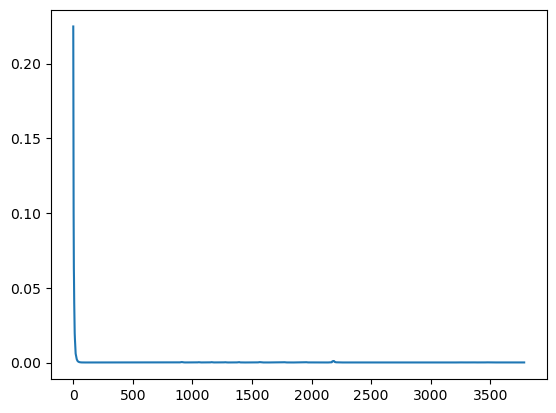

In [161]:
model,losses = train_model(model,n_epochs=3,train_loader=train_loader,loss_function=loss_function,optimizer=optimizer)
plot_loss(losses=losses,window_size=20)

In [162]:
r = model(train_data).detach().numpy()
train = train_data.numpy()
l = model.encoder(train_data).detach().numpy()

In [163]:
model.eval()  # Set the model to evaluation mode
reconstruction_errors = []

# Calculate reconstruction errors for each feature
with torch.no_grad():
    for profile in train_loader:
        reconstructed = model(profile)
        error = (reconstructed - profile).pow(2).mean(dim=0)  # MSE per feature
        reconstruction_errors.append(error.numpy())

# Average errors across all batches
avg_reconstruction_errors = np.mean(reconstruction_errors, axis=0)


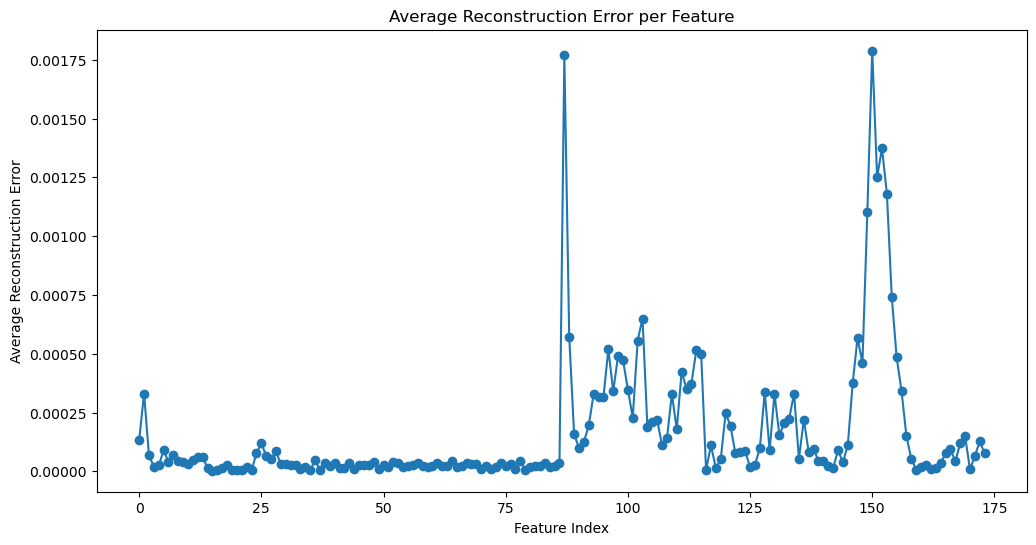

In [164]:
plt.figure(figsize=(12, 6))
plt.plot(avg_reconstruction_errors, marker='o')
plt.xlabel('Feature Index')
plt.ylabel('Average Reconstruction Error')
plt.title('Average Reconstruction Error per Feature')
plt.show()


High reconstruction error for certain features indicates that there may be greater variability within these features. Motivates a deeper examination of them. 

### Compare dimensionality reduction techniques

In [167]:
# get latent representations from AE 

model.eval()
with torch.no_grad():
    latent_representations = model.encoder(train_data).detach().numpy()

In [168]:
# apply PCA on original data 

pca = PCA(n_components=latent_representations.shape[1])  #same dimensionality as AE latent space
pca_representations = pca.fit_transform(X)

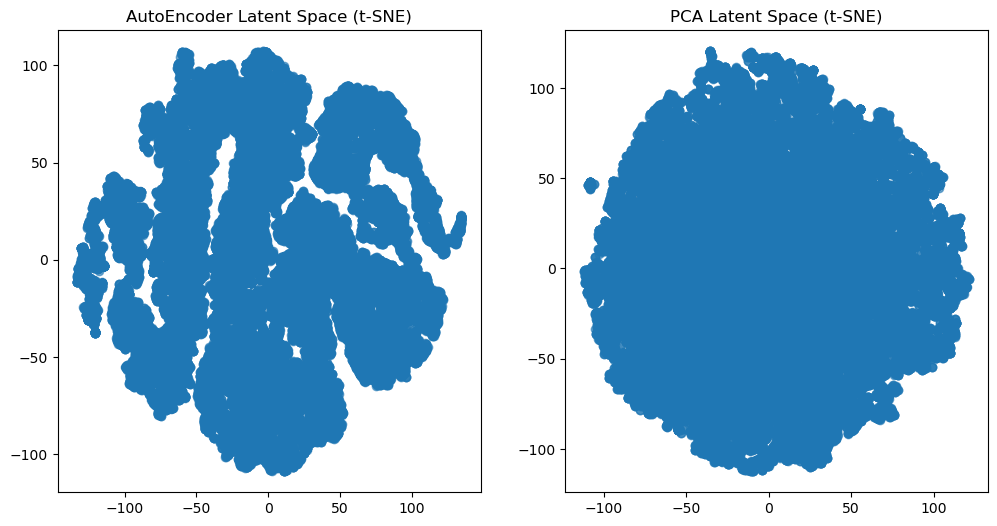

In [169]:
from sklearn.manifold import TSNE

# AutoEncoder latent space
tsne_ae = TSNE(n_components=2, random_state=1)
ae_2d = tsne_ae.fit_transform(latent_representations)

# PCA latent space
tsne_pca = TSNE(n_components=2, random_state=1)
pca_2d = tsne_pca.fit_transform(pca_representations)

# Plotting
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(ae_2d[:, 0], ae_2d[:, 1], alpha=0.6)
plt.title('AutoEncoder Latent Space (t-SNE)')

plt.subplot(1, 2, 2)
plt.scatter(pca_2d[:, 0], pca_2d[:, 1], alpha=0.6)
plt.title('PCA Latent Space (t-SNE)')

plt.show()

Both techniques not capturing clear patterns. Potential improvement: different weights for features based on their reconstruction difficulty.

In [171]:
#calculate weights based on reconstruction error 
feature_weights = avg_reconstruction_errors / np.max(avg_reconstruction_errors)
feature_weights = torch.tensor(feature_weights, dtype=torch.float32)

In [172]:
#weighted mse loss
import torch.nn.functional as F

def weighted_mse_loss(reconstructed, original, weights):
    loss = weights * (reconstructed - original).pow(2)
    return loss.mean()


In [173]:
#update training to incorporate 


def train_model_with_weighted_loss(model, train_loader, n_epochs, optimizer, feature_weights):
    losses = []
    model.train()
    for _ in range(n_epochs):
        for profile in train_loader:
            # Forward pass
            reconstructed = model(profile)
            # Compute weighted loss
            loss = weighted_mse_loss(reconstructed, profile, feature_weights)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
    return model, losses


In [174]:
#re train 

model2 = AutoEncoder(latent_dim=16)  
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-8)

model2, losses = train_model_with_weighted_loss(model, train_loader=train_loader, n_epochs=3, optimizer=optimizer, feature_weights=feature_weights)


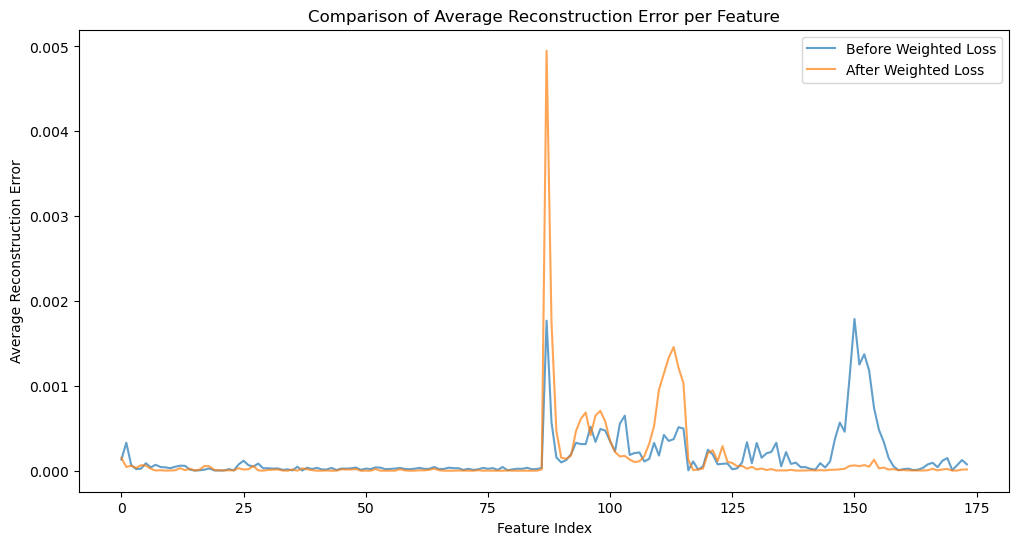

In [175]:
model2.eval()
weighted_reconstruction_errors = []

with torch.no_grad():
    for profile in train_loader:
        reconstructed = model(profile)
        error = (reconstructed - profile).pow(2).mean(dim=0)  # MSE per feature
        weighted_reconstruction_errors.append(error.numpy())

avg_weighted_reconstruction_errors = np.mean(weighted_reconstruction_errors, axis=0)

# Plot to compare
plt.figure(figsize=(12, 6))
plt.plot(avg_reconstruction_errors, label="Before Weighted Loss", alpha=0.7)
plt.plot(avg_weighted_reconstruction_errors, label="After Weighted Loss", alpha=0.7)
plt.xlabel('Feature Index')
plt.ylabel('Average Reconstruction Error')
plt.legend()
plt.title('Comparison of Average Reconstruction Error per Feature')
plt.show()


#### clustering in latent space

/opt/anaconda3/envs/columbia/lib/python3.9/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


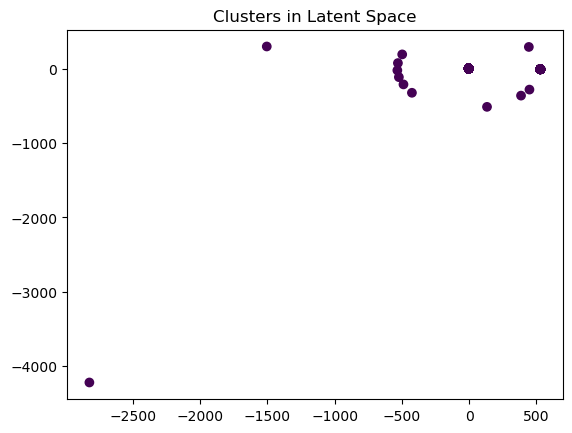

In [177]:
from sklearn.cluster import KMeans

latent_representations = model.encoder(train_data).detach().numpy()
kmeans = KMeans(n_clusters=4, random_state=1)  # Choose an appropriate number of clusters
clusters = kmeans.fit_predict(latent_representations)

tsne = TSNE(n_components=2, random_state=1)
latent_2d = tsne.fit_transform(latent_representations)
plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=clusters, cmap="viridis")
plt.title("Clusters in Latent Space")
plt.show()


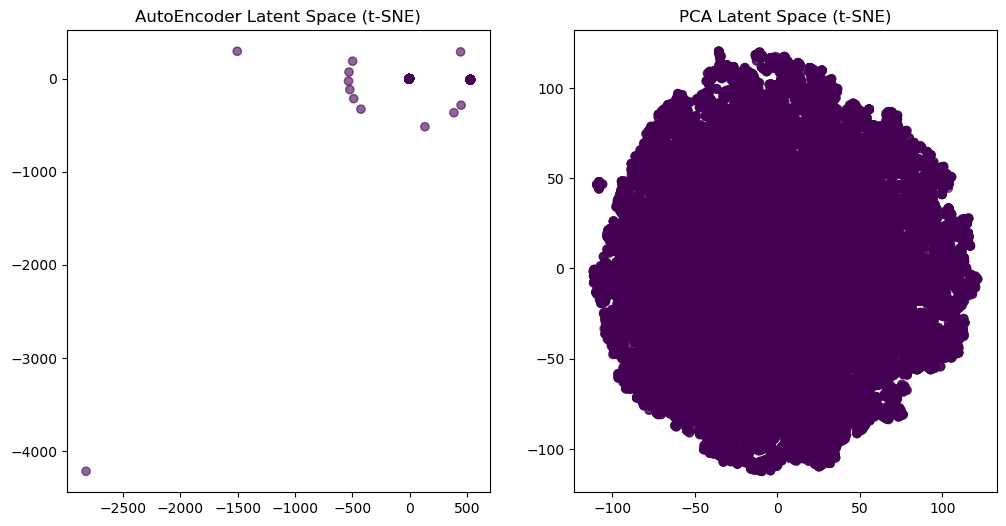

In [178]:
model.eval()
with torch.no_grad():
    latent_representations = model.encoder(train_data).detach().numpy()
tsne_ae = TSNE(n_components=2, random_state=1)
ae_2d = tsne_ae.fit_transform(latent_representations)

# t-SNE on PCA latent space
tsne_pca = TSNE(n_components=2, random_state=1)
pca_2d = tsne_pca.fit_transform(pca_representations)

# Plot the t-SNE results for comparison
plt.figure(figsize=(12, 6))

# AutoEncoder latent space
plt.subplot(1, 2, 1)
plt.scatter(ae_2d[:, 0], ae_2d[:, 1], c=clusters, cmap="viridis", alpha=0.6)
plt.title("AutoEncoder Latent Space (t-SNE)")

# PCA latent space
plt.subplot(1, 2, 2)
plt.scatter(pca_2d[:, 0], pca_2d[:, 1], c=clusters, cmap="viridis", alpha=0.6)
plt.title("PCA Latent Space (t-SNE)")

plt.show()